In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch

from camera_calib_python.calib import single_calib_f
from camera_calib_python.cb_geom import CbGeom, CpCSRGrid, FmCFPGrid
from camera_calib_python.control_refine import (CheckerRefiner,
                                                OpenCVCheckerRefiner)
from camera_calib_python.fiducial_detect import DotVisionCheckerDLDetector
from camera_calib_python.image import File16bitImg
from camera_calib_python.modules import *
from camera_calib_python.utils import *

In [2]:
from IPython.core.debugger import set_trace

# Image file name parsing

Need to get image path, pose, and camera so we can construct coordinate graph.

In [3]:
dir_data = Path('data/dot_vision_checker')

In [4]:
files_img = list(dir_data.glob('*.png'))
files_img

[PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1.png')]

In [5]:
def _parse_name(name_img):
    match = re.match(r"""SERIAL_(?P<serial>.*)_
                         DATETIME_(?P<date>.*)_
                         CAM_(?P<cam>.*)_
                         FRAMEID_(?P<frameid>.*)_
                         COUNTER_(?P<counter>.*).png""", 
                     name_img, 
                     re.VERBOSE)
    return match.groupdict()

In [6]:
df_icp = pd.DataFrame(columns=['img', 'idx_cam', 'idx_pos'])
for file_img in files_img:
    dict_group = _parse_name(file_img.name)
    df_icp = df_icp.append({'img': File16bitImg(file_img),
                            'idx_cam': int(dict_group['cam'])-1,
                            'idx_pos': int(dict_group['counter'])-1}, ignore_index=True)

In [7]:
df_icp

,img,idx_cam,idx_pos
0,File16bitImg(SERIAL_16276941_DATETIME_2019-06-...,1,1
1,File16bitImg(SERIAL_19061245_DATETIME_2019-06-...,0,0
2,File16bitImg(SERIAL_16276942_DATETIME_2019-06-...,2,0
3,File16bitImg(SERIAL_16276942_DATETIME_2019-06-...,2,1
4,File16bitImg(SERIAL_16276941_DATETIME_2019-06-...,1,0


# Initialize

Camera calibration stuff

In [8]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

In [9]:
file_model = Path('models/dot_vision_checker.pth')
detector = DotVisionCheckerDLDetector(file_model)

In [10]:
refiner = OpenCVCheckerRefiner(hw_min=5, hw_max=15, cutoff_it=20, cutoff_norm=1e-3)

Get and order camera and pos indices

In [11]:
idxs_cam = np.sort(df_icp.idx_cam.unique())
idxs_pos = np.sort(df_icp.idx_pos.unique())

In [12]:
assert_allclose(idxs_cam, np.arange(len(idxs_cam)))
assert_allclose(idxs_pos, np.arange(len(idxs_pos)))

Do single camera calibration and store results in coordinate graph

In [13]:
class Node:
    def __init__(self, label):
        self.label = label
        self.M = None # Affine transfrom from this coordinate system to the root coordinate system
        
    def __repr__(self):
        return f'{self.__class__.__name__}({self.label})'

In [14]:
class CamNode(Node):
    def __init__(self, label, cam, distort):
        super().__init__(label)
        self.cam, self.distort = cam, distort

In [15]:
class PosNode(Node):
    def __init__(self, label):
        super().__init__(label)

In [16]:
G = nx.DiGraph()

In [17]:
nodes_pos = [PosNode(idx_pos) for idx_pos in idxs_pos]
nodes_cam = []
df_icp['ps_c_p'] = pd.Series([], dtype=object) # Initializes column type
for idx_cam in np.sort(df_icp.idx_cam.unique()):
    imgs_cam = df_icp[df_icp.idx_cam == idx_cam].img.to_list()
    cam, distort, rigids, (pss_c_p, _) = single_calib(imgs_cam, cb_geom, detector, refiner)
    df_icp.loc[df_icp[df_icp.idx_cam == idx_cam].index, 'ps_c_p'] = pss_c_p
    node_cam = CamNode(idx_cam, cam, distort)
    for img_cam, m_rigid in zip(imgs_cam, rigids):
        row_icp = df_icp[df_icp.img == img_cam]
        node_pos = nodes_pos[row_icp.idx_pos.item()]
        G.add_edge(node_pos, node_cam, m_rigid=m_rigid)
        G.add_edge(node_cam, node_pos, m_rigid=Inverse(m_rigid))
    nodes_cam.append(node_cam)

Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1...
Refining parameters...
 - Iteration: 000 - Norm:    0.00483 - Loss:    5.36058
 - Iteration: 001 - Norm:    0.15146 - Loss:    3.71881
 - Iteration: 002 - Norm:    3.92902 - Loss:    3.49835
 - Iteration: 003 - Norm:    7.61183 - Loss:    3.26027
 - Iteration: 004 - Norm:   53.26645 - Loss:    1.69542
 - Iteration: 005 - Norm:    0.00000 - Loss:    1.69542
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2...
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1...
Refining parameters...
 - Iteration: 000 - Norm:    0.04100 - Loss:  145.66077
 - Iteration: 001 - Norm:    0.13687 - Loss:   83.93632
 - Iteration: 002 - Norm:    0.84322 - Loss:    3.98970
 - Iteration: 003 - Norm:    0.27753 - Loss:    3.59056
 - Iteration: 004 - Norm:    6.16048 - Loss:    3.37696
 - Itera

In [18]:
df_icp

,img,idx_cam,idx_pos,ps_c_p
0,File16bitImg(SERIAL_16276941_DATETIME_2019-06-...,1,1,"[[1071.9211135484697, 565.8056310561878], [102..."
1,File16bitImg(SERIAL_19061245_DATETIME_2019-06-...,0,0,"[[1561.8121472966093, 770.4002155480954], [154..."
2,File16bitImg(SERIAL_16276942_DATETIME_2019-06-...,2,0,"[[1278.5818720675918, 816.6561685414962], [124..."
3,File16bitImg(SERIAL_16276942_DATETIME_2019-06-...,2,1,"[[860.2190376313916, 635.1841570918837], [820...."
4,File16bitImg(SERIAL_16276941_DATETIME_2019-06-...,1,0,"[[1505.8628106094825, 775.0347973776888], [147..."


In [19]:
def draw_bipartite(G, nodes_cam, nodes_pos):
    def _get_p(nodes, x):
        return {node: (x, y) for node,y in zip(nodes, np.linspace(0, 1, len(nodes)))}

    nx.draw(G, 
            node_color=['g' if isinstance(node, CamNode) else 'r' for node in G], 
            pos={**_get_p(nodes_cam, 0), 
                 **_get_p(nodes_pos, 1)}, 
            with_labels=True)
    plt.xlim(-0.5, 1.5);
    plt.ylim(-0.5, 1.5);

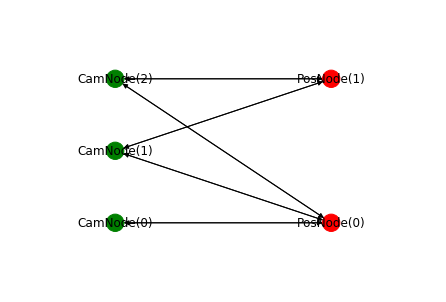

In [20]:
draw_bipartite(G, nodes_cam, nodes_pos)

Do BFS and compose transforms to get the transform from each coordinate node to the root node (master camera)

In [21]:
node_root = nodes_cam[0]

In [22]:
node_root.M = torch.eye(4, dtype=torch.double)
for (node_prnt, node_chld) in nx.bfs_edges(G, node_root):
    node_chld.M = node_prnt.M@G.get_edge_data(node_chld, node_prnt)['m_rigid'].get_param()

Gather modules

In [23]:
cams = [nodes_cam[idx].cam for idx in idxs_cam]
distorts = [nodes_cam[idx].distort for idx in idxs_cam]
rigids_pos = [Rigid(*M2Rt(nodes_pos[idx].M)) for idx in idxs_pos]
rigids_cam = [Rigid(*M2Rt(invert_rigid(nodes_cam[idx].M))) for idx in idxs_cam]

Get ms_w2p transformations

In [24]:
df_icp

,img,idx_cam,idx_pos,ps_c_p
0,File16bitImg(SERIAL_16276941_DATETIME_2019-06-...,1,1,"[[1071.9211135484697, 565.8056310561878], [102..."
1,File16bitImg(SERIAL_19061245_DATETIME_2019-06-...,0,0,"[[1561.8121472966093, 770.4002155480954], [154..."
2,File16bitImg(SERIAL_16276942_DATETIME_2019-06-...,2,0,"[[1278.5818720675918, 816.6561685414962], [124..."
3,File16bitImg(SERIAL_16276942_DATETIME_2019-06-...,2,1,"[[860.2190376313916, 635.1841570918837], [820...."
4,File16bitImg(SERIAL_16276941_DATETIME_2019-06-...,1,0,"[[1505.8628106094825, 775.0347973776888], [147..."


In [25]:
df_icp['m_w2p'] = pd.Series([], dtype=object) # Initializes column type
for idx, row_icp in df_icp.iterrows():
     df_icp.loc[idx, 'm_w2p'] = torch.nn.Sequential(rigids_pos[row_icp.idx_pos],
                                                    rigids_cam[row_icp.idx_cam],
                                                    Normalize(), 
                                                    distorts[row_icp.idx_cam], 
                                                    cams[row_icp.idx_cam])

In [26]:
df_icp.ps_c_p = df_icp.ps_c_p.apply(torch.DoubleTensor)

root camera has identity xform which shouldn't get updated

In [27]:
for p in rigids_cam[0].parameters():
    p.requires_grad_(False)

In [28]:
def _get_params(): # skip first rigid_cam, which is just identity transform
    return sum([list(m.parameters()) for m in cams + distorts + rigids_cam[1:] + rigids_pos], [])

In [29]:
# export
def SSE(x1, x2): return ((x1-x2)**2).sum()

In [30]:
# Do nonlinear optimization
def _get_loss():
    ls = []
    for _, row_icp in df_icp.iterrows():
        m_w2p, ps_c_p = row_icp.m_w2p, row_icp.ps_c_p
        idx = torch.where(torch.all(torch.isfinite(ps_c_p), dim=1))[0]
        ls.append(loss(ps_c_p[idx], m_w2p(ps_c_w[idx])))
    return sum(ls)

In [31]:
ps_c_w = cb_geom.ps_c

In [32]:
ps_c_w = torch.DoubleTensor(np.c_[ps_c_w, np.zeros(len(ps_c_w))]) # 3rd dimension is zero

In [34]:
cutoff_it = 500
cutoff_norm = 1e-6
loss = SSE

In [36]:
_get_loss()

tensor(15.7325, dtype=torch.float64, grad_fn=<AddBackward0>)

In [37]:
optim = torch.optim.LBFGS(_get_params())

In [38]:
pss_c_p_m = []
for _, row_icp in df_icp.iterrows():
    m_w2p, ps_c_p = row_icp.m_w2p, row_icp.ps_c_p
    pss_c_p_m.append(m_w2p(ps_c_w))

In [39]:
pss_c_p = []
for _, row_icp in df_icp.iterrows():
    pss_c_p.append(row_icp.ps_c_p)

In [40]:
debug = torch2np((tuple(pss_c_p), tuple(pss_c_p_m))) 

(-0.25, 0.25)

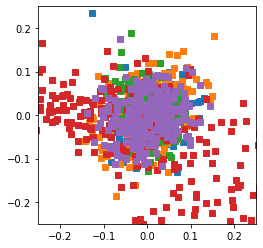

In [41]:
for p1, p2 in zip(debug[0], debug[1]):
    res = (p1-p2)
    plt.plot(res[:,0], res[:,1], 's')
plt.gca().set_aspect(1)
plt.gca().set_xlim(-0.25, 0.25)
plt.gca().set_ylim(-0.25, 0.25)

In [42]:
params_prev = torch.cat([p.view(-1) for p in _get_params()])
for it in range(cutoff_it):
    def _closure():
        optim.zero_grad()
        l = _get_loss()
        l.backward()
        return l
    optim.step(_closure)
    params = torch.cat([p.view(-1) for p in _get_params()])
    norm = torch.norm(params-params_prev)
    print(f' - Iteration: {it:03d} - Norm: {norm.item():10.5f} - Loss: {_get_loss().item():10.5f}')
    if norm < cutoff_norm: break
    params_prev = params

 - Iteration: 000 - Norm:    0.00056 - Loss:   10.38034
 - Iteration: 001 - Norm:    0.00082 - Loss:    8.47968
 - Iteration: 002 - Norm:    0.00098 - Loss:    8.07391
 - Iteration: 003 - Norm:    0.00099 - Loss:    7.88472
 - Iteration: 004 - Norm:    0.00292 - Loss:    7.64915
 - Iteration: 005 - Norm:    0.00345 - Loss:    7.46645
 - Iteration: 006 - Norm:    0.00588 - Loss:    7.30868
 - Iteration: 007 - Norm:    0.00090 - Loss:    7.29254
 - Iteration: 008 - Norm:    0.00219 - Loss:    7.28159
 - Iteration: 009 - Norm:    0.00238 - Loss:    7.26833
 - Iteration: 010 - Norm:    0.00568 - Loss:    7.24649
 - Iteration: 011 - Norm:    0.00368 - Loss:    7.23508
 - Iteration: 012 - Norm:    0.01295 - Loss:    7.20371
 - Iteration: 013 - Norm:    0.00073 - Loss:    7.20276
 - Iteration: 014 - Norm:    0.00656 - Loss:    7.19368
 - Iteration: 015 - Norm:    0.02478 - Loss:    7.16473
 - Iteration: 016 - Norm:    0.00021 - Loss:    7.16465
 - Iteration: 017 - Norm:    0.05316 - Loss:    

In [43]:
pss_c_p_m = []
for _, row_icp in df_icp.iterrows():
    m_w2p, ps_c_p = row_icp.m_w2p, row_icp.ps_c_p
    pss_c_p_m.append(m_w2p(ps_c_w))

In [44]:
pss_c_p = []
for _, row_icp in df_icp.iterrows():
    pss_c_p.append(row_icp.ps_c_p)

In [45]:
debug = torch2np((tuple(pss_c_p), tuple(pss_c_p_m))) 

(-0.25, 0.25)

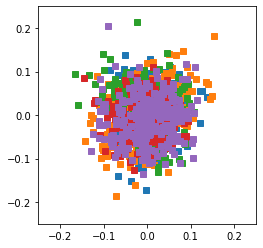

In [46]:
for p1, p2 in zip(debug[0], debug[1]):
    res = (p1-p2)
    plt.plot(res[:,0], res[:,1], 's')
plt.gca().set_aspect(1)
plt.gca().set_xlim(-0.25, 0.25)
plt.gca().set_ylim(-0.25, 0.25)

In [47]:
cams

[CamSF(alpha:3.59e+03 x_o:974.5 y_o:763.5),
 CamSF(alpha:3.572e+03 x_o:1.038e+03 y_o:788.0),
 CamSF(alpha:3.48e+03 x_o:1.118e+03 y_o:734.3)]

In [48]:
rigids_cam

[Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:0.0 ey:-0.0 ez:0.0)
     (1): Translation(tx:0.0 ty:0.0 tz:0.0)
   )
 ), Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:0.003261 ey:0.3904 ez:-0.003991)
     (1): Translation(tx:-83.43 ty:0.0831 tz:-7.064)
   )
 ), Rigid(
   (ms): ModuleList(
     (0): EulerRotation(ex:-0.03141 ey:0.7848 ez:-0.02494)
     (1): Translation(tx:-153.9 ty:1.597 tz:58.07)
   )
 )]